In [1]:
conda install libpython m2w64-toolchain -c msys2

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sdasgupt\AppData\Local\Continuum\anaconda3

  added / updated specs:
    - libpython
    - m2w64-toolchain


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py37_0         2.8 MB
    libpython-2.1              |           py37_0          47 KB
    m2w64-binutils-2.25.1      |                5        44.3 MB  msys2
    m2w64-bzip2-1.0.6          |                6         100 KB  msys2
    m2w64-crt-git-5.0.0.4636.2595836|                2         3.4 MB  msys2
    m2w64-gcc-5.3.0            |                6        41.1 MB  msys2
    m2w64-gcc-ada-5.3.0        |                6        33.5 MB  msys2
    m2w64-gcc-fortran-5.3.0    |                6        10.3 MB  msys2
    m2w64-gcc-objc-5.3.0       |                6        15.1 MB  msys2
    m2w64-head

In [2]:
pip install pystan

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fbprophet

  Using cached https://files.pythonhosted.org/packages/f7/86/4509e952f9724f084625e93e0bf8d8519b25c79029a0a916b0f996644c75/fbprophet-0.6.tar.gz
  Stored in directory: C:\Users\sdasgupt\AppData\Local\pip\Cache\wheels\2c\59\69\10ed740f4edb86e44e7c4d80537fbf3112dbc25f3624effba5
Successfully built fbprophet
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [5]:
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

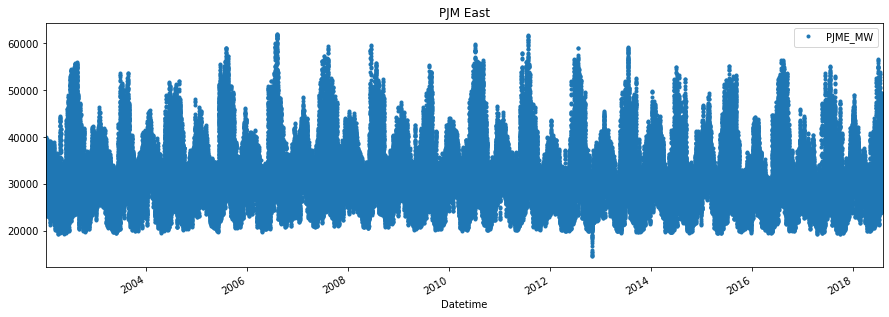

In [6]:
pjme.plot(style='.', figsize=(15,5), title='PJM East')

In [7]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
PJME_MW    145366 non-null float64
dtypes: float64(1)
memory usage: 2.2 MB


In [8]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
X, y = create_features(pjme, label='PJME_MW')


In [10]:
X.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


In [11]:
y.head()

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
Name: PJME_MW, dtype: float64

In [12]:
features_and_target = pd.concat([X, y], axis=1)

In [13]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


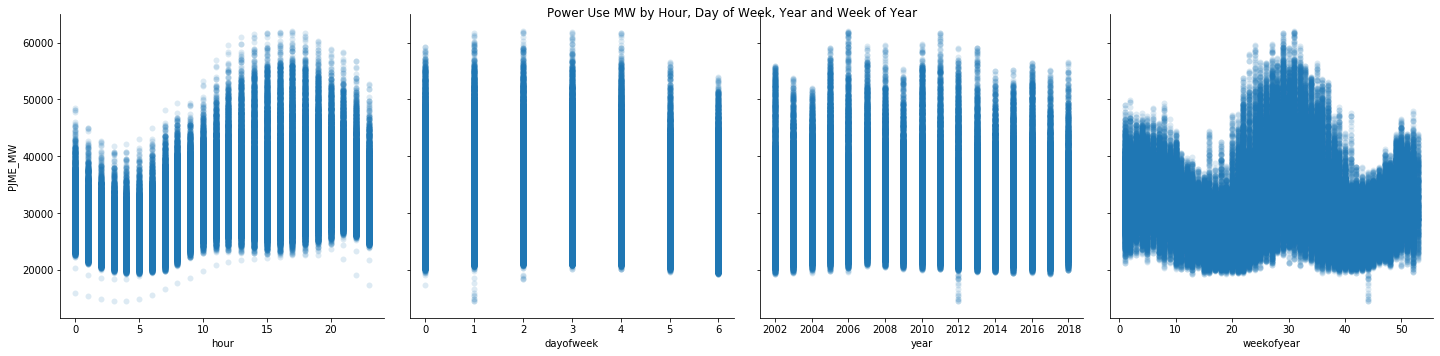

In [15]:
sns.pairplot(features_and_target.dropna(),
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [16]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [19]:
pjme_train.head()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


In [20]:
pjme_test.head()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2015-12-31 01:00:00,24305.0,2015-12-31 01:00:00,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,23156.0,2015-12-31 02:00:00,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,22514.0,2015-12-31 03:00:00,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,22330.0,2015-12-31 04:00:00,4,3,4,12,2015,365,31,53
2015-12-31 05:00:00,22773.0,2015-12-31 05:00:00,5,3,4,12,2015,365,31,53


In [22]:
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
1,2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2,2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
3,2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
4,2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


In [23]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))


In [24]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [25]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31206.543212,23761.956003,32913.717557,31206.543212,31206.543212,-2819.738727,-2819.738727,-2819.738727,-4430.377400,...,1281.434795,1281.434795,1281.434795,329.203877,329.203877,329.203877,0.0,0.0,0.0,28386.804485
1,2015-01-01 02:00:00,31206.504746,22609.445136,31450.318601,31206.504746,31206.504746,-4324.062997,-4324.062997,-4324.062997,-5927.279402,...,1272.676023,1272.676023,1272.676023,330.540381,330.540381,330.540381,0.0,0.0,0.0,26882.441749
2,2015-01-01 03:00:00,31206.466280,21348.349392,30465.489064,31206.466280,31206.466280,-5195.717080,-5195.717080,-5195.717080,-6790.347125,...,1262.711700,1262.711700,1262.711700,331.918345,331.918345,331.918345,0.0,0.0,0.0,26010.749200
3,2015-01-01 04:00:00,31206.427814,21354.943686,30367.183588,31206.427814,31206.427814,-5337.237915,-5337.237915,-5337.237915,-6922.241116,...,1251.665408,1251.665408,1251.665408,333.337793,333.337793,333.337793,0.0,0.0,0.0,25869.189899
4,2015-01-01 05:00:00,31206.389348,21944.626431,30753.254847,31206.389348,31206.389348,-4662.874028,-4662.874028,-4662.874028,-6237.345713,...,1239.672935,1239.672935,1239.672935,334.798749,334.798749,334.798749,0.0,0.0,0.0,26543.515320


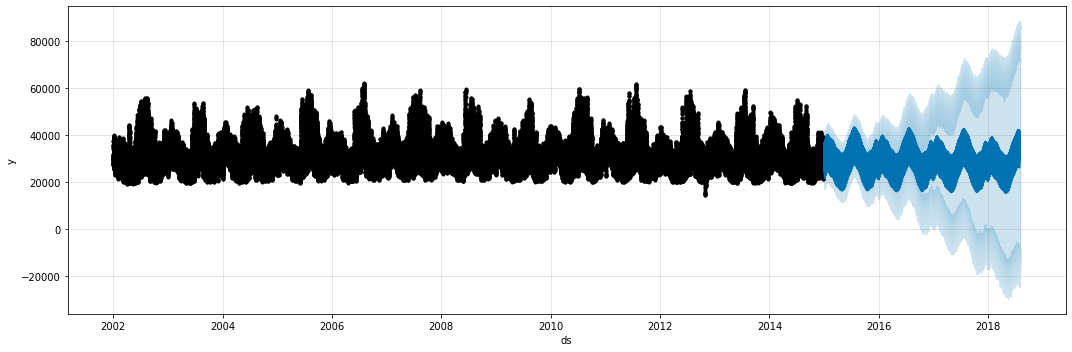

In [26]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

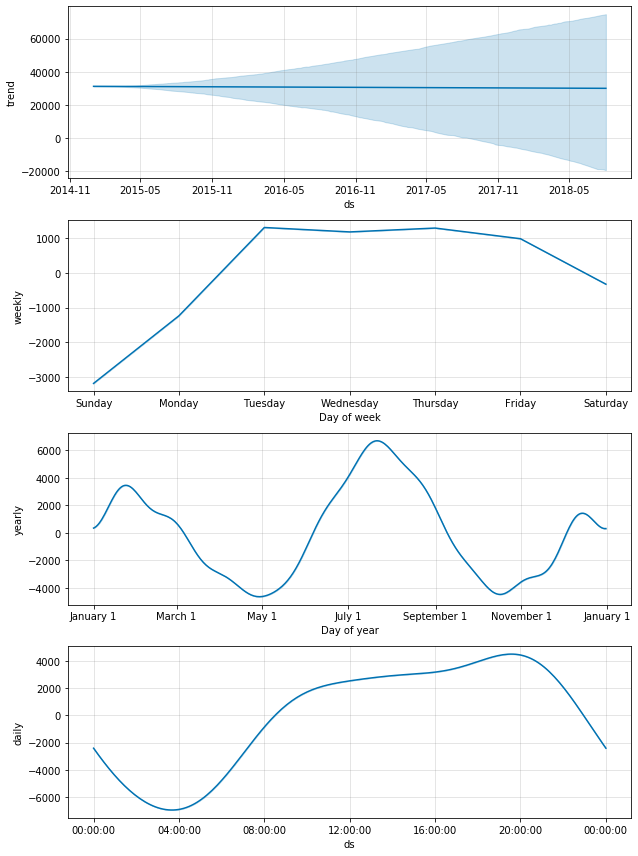

In [27]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

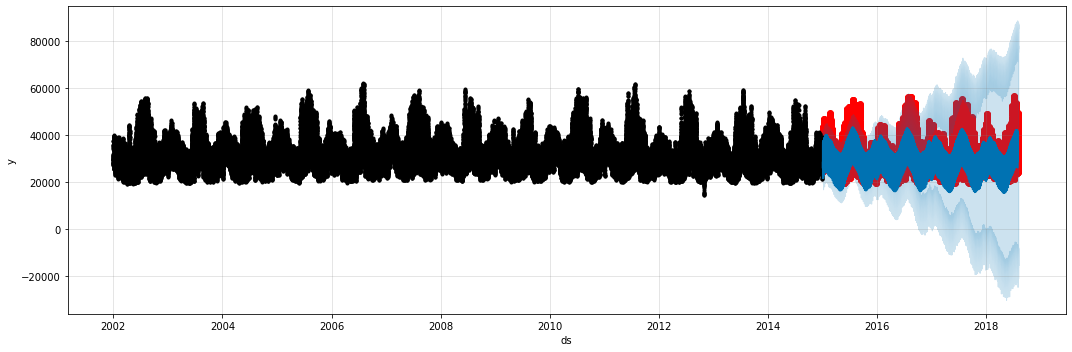

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: '01-01-2015'

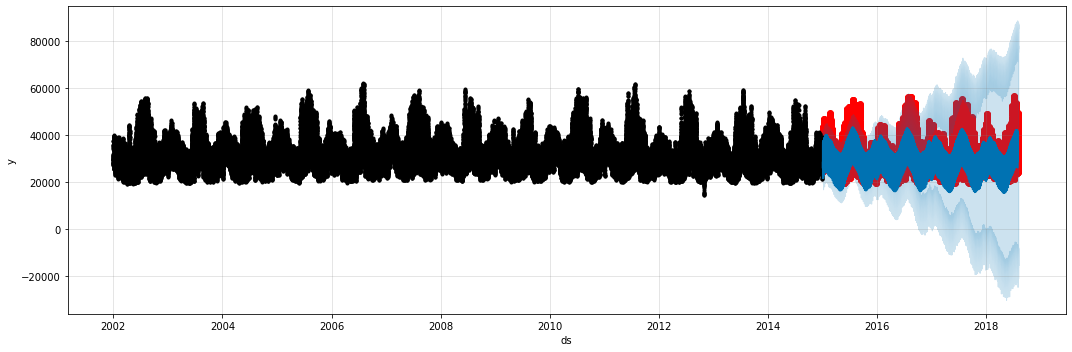

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [ ]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

In [ ]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [ ]:
error_by_day.head()

In [ ]:
error_by_day.sort_values('error', ascending=True).head(10)

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()